## Makemore part: 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('/content/shuffled_names1.txt', 'r').read().splitlines()
words[:8]

['udhav',
 'aranya',
 'amirthavarshani',
 'atesha',
 'thaveesha',
 'inchar',
 'subaraja',
 'nivarshayan']

In [3]:
#build the vocabulary of characters and the mappings to/from characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 8# context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([404362, 8]) torch.Size([404362])
torch.Size([50327, 8]) torch.Size([50327])
torch.Size([50634, 8]) torch.Size([50634])


In [5]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> c
.......c ---> h
......ch ---> i
.....chi ---> t
....chit ---> h
...chith ---> r
..chithr ---> a
.chithra ---> y
chithray ---> e
hithraye ---> n
ithrayen ---> .
........ ---> g
.......g ---> i
......gi ---> r
.....gir ---> i
....giri ---> j
...girij ---> a
..girija ---> n
.girijan ---> a
girijana ---> .


In [6]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: #32, 68
        dim = 0
      elif x.ndim == 3: #32, 4, 68. this update allows the mean to be calculated across 32 x 4 numbers which allows
          #the running_mean to be stable and less wiggly. same for running_var
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [7]:
torch.manual_seed(42);

In [8]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

layers = [
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    #Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

model = Sequential(layers)

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  model.layers[-1].weight *= 0.1
  # all other layers: apply gain
  # for layer in layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 1.0 #5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [9]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0, 25,  8,  1, 20,  8, 21, 14],
        [ 0,  0,  0,  0,  0,  0, 19,  9],
        [ 0,  0,  0,  0,  1, 19,  9, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2907
  10000/ 200000: 1.6238
  20000/ 200000: 1.7013
  30000/ 200000: 1.5939
  40000/ 200000: 2.1512
  50000/ 200000: 2.0319
  60000/ 200000: 1.8505
  70000/ 200000: 1.7561
  80000/ 200000: 1.5630
  90000/ 200000: 1.9835
 100000/ 200000: 1.6204
 110000/ 200000: 2.1017
 120000/ 200000: 1.6831
 130000/ 200000: 1.8140
 140000/ 200000: 1.7833
 150000/ 200000: 1.7657
 160000/ 200000: 1.7605
 170000/ 200000: 1.7631
 180000/ 200000: 1.7652
 190000/ 200000: 1.8927


In [11]:
Xb.shape

torch.Size([32, 8])

In [12]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [13]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [ ]:
#plt.plot(lossi) ~andrej said delete this monster :)

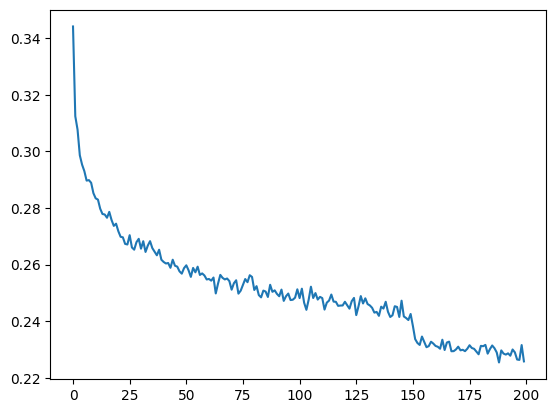

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [15]:
#put layers in eval mode
for layer in layers:
    layer.training = False

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.6854639053344727
val 1.7740538120269775


In [18]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

pavithra.
soshisami.
mohit.
swali.
dinoganathan.
yohsotya.
jayvini.
yarishan.
vishanth.
poonnan.
vaneeshi.
saroch.
prathvik.
uthanya.
muthushkar.
tanishkumuni.
gumayodan.
vanurthara.
gandham.
vineeshan.
